In [168]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/naomiverkerk/TM10007.git


In [169]:
## Import
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from load_data import load_data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Classifiers and kernels
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report



In [170]:
##Loading Data
data = load_data() 
X = data
X = X.replace(np.inf, np.nan)
Y = data['label']
del X['label']

In [171]:
## Split
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size = 0.2, random_state = 4, stratify = Y)

In [172]:

## Features weghalen met teveel missing values
acceptabele_ratio = 0.5
train_size = len(X_train.index)
removal_rate = round(train_size*acceptabele_ratio)

X_train = X_train.dropna(axis=1, thresh=removal_rate)
common_cols = list(set(X_train.columns).intersection(X_test.columns))
X_test = X_test[common_cols]

In [173]:
## Imputation met median
X_train_missing_median = X_train.fillna(X_train.median())
X_train_missing_median = np.nan_to_num(X_train_missing_median)
X_test_missing_median = X_test.fillna(X_test.median())
X_test_missing_median = np.nan_to_num(X_test_missing_median)

In [174]:
## Scaling
scaler = preprocessing.RobustScaler()
scaler.fit(X_train_missing_median)
X_train_scaled = scaler.transform(X_train_missing_median)
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = scaler.transform(X_test_missing_median)
X_test_scaled = np.nan_to_num(X_test_scaled)

In [175]:
scaler_y = preprocessing.LabelEncoder()
scaler_y.fit(np.array(Y_train))
Y_train_final = scaler_y.transform(np.array(Y_train))
Y_test_final =  scaler_y.transform(np.array(Y_test))

In [176]:
## PCA
pca = decomposition.PCA(n_components=0.99, svd_solver= 'full')
pca.fit(X_train_scaled)
X_train_final = pca.transform(X_train_scaled)
X_test_final = pca.transform(X_test_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)


In [177]:
# def flatten(t):
#     return [item for sublist in t for item in sublist]
# x = flatten(X_train_final[:,1:2])
# y = flatten(X_train_final[:,2:3])
# sns.scatterplot( x=x, y=y, hue=Y_train_final)

The optimal solver=newton-cg
The optimal C=100.0


,auc,solver,C,set
0,0.914773,newton-cg,100.0,test
1,0.914773,newton-cg,100.0,validation
2,0.778409,newton-cg,0.1,test
3,0.778409,newton-cg,0.1,validation
4,0.694118,newton-cg,100.0,test
5,0.694118,newton-cg,100.0,validation
6,0.893750,liblinear,100.0,test
7,0.893750,liblinear,100.0,validation
8,0.931250,newton-cg,100.0,test
9,0.931250,newton-cg,100.0,validation


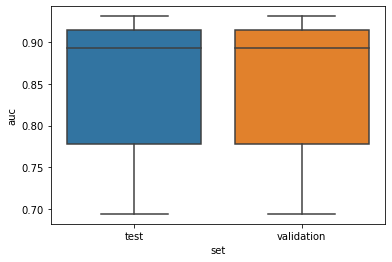

In [213]:
import warnings
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import statistics
# Create a 20 fold stratified CV iterator

cv_20fold = model_selection.StratifiedKFold(n_splits=5)
results = []
best_n_neighbors = []
n_components = []


# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_final, Y_train_final):
    # Split the data properly
    X_validation = X_train_final[validation_index]
    y_validation = Y_train_final[validation_index]

    X_test = X_train_final[test_index]
    y_test = Y_train_final[test_index]

    parameters = {
                    "solver": ['newton-cg', 'lbfgs', 'liblinear'],
                    "C": [100, 10, 1.0, 0.1, 0.01],
    }

    lg = LogisticRegression()
    cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    grid_search = model_selection.GridSearchCV(lg, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)

    clf = grid_search.best_estimator_

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        "solver": clf.solver,
        "C": clf.C,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc,
        "solver": clf.solver,
        "C": clf.C,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results)

optimal_parameter = []
parameter_keys = list(parameters.keys())

for item in parameter_keys:
    best_item = [] 
    for i in list(range(0,10,2)):
        best_item.append(results[item][i])
    
    optimal_parameter.append(statistics.median(best_item))
    print(f"The optimal {item}={optimal_parameter[-1]}")

results


In [179]:
# from sklearn.datasets import load_iris
# iris = load_iris()

# from matplotlib import pyplot as plt

# # The indices of the features that we are plotting
# x_index = 0
# y_index = 1

# # this formatter will label the colorbar with the correct target names
# formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])

# plt.figure(figsize=(5, 4))
# plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
# plt.colorbar(ticks=[0, 1, 2], format=formatter)
# plt.xlabel(iris.feature_names[x_index])
# plt.ylabel(iris.feature_names[y_index])

# plt.tight_layout()
# plt.show()

In [180]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

iris = load_iris()

X = iris.data[50:150]
X = X[:,[0,1]]
y = iris.target[50:150]
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
# # Standardize X

# sc = StandardScaler()
# sc.fit(X_train)
# X_train= sc.transform(X_train)
# X_test = sc.transform(X_test)

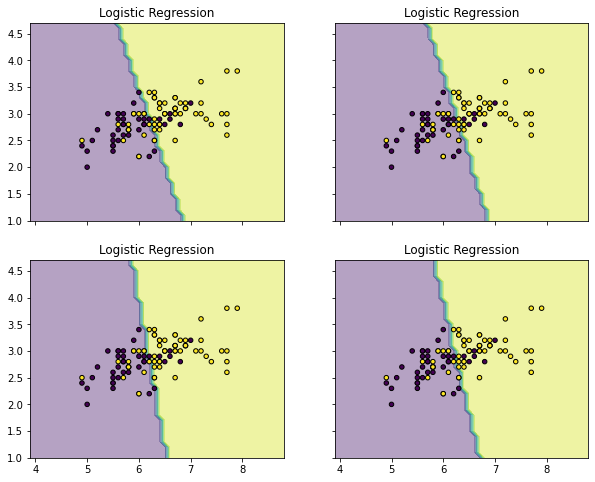

,auc,set
0,0.675,test
1,0.675,validation
2,0.785,test
3,0.785,validation
4,0.710,test
5,0.710,validation
6,0.900,test
7,0.900,validation
8,0.960,test
9,0.960,validation


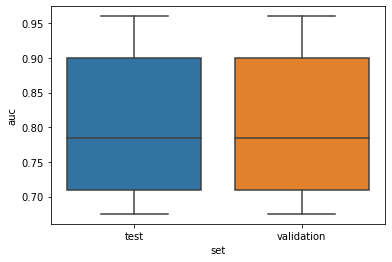

In [181]:
cv_20fold = model_selection.StratifiedKFold(n_splits=5)
results = []
best_n_neighbors = []
clf = []


# Loop over the folds
for validation_index, test_index in cv_20fold.split(X, y):
    # Split the data properly
    X_validation = X[validation_index]
    y_validation = y[validation_index]

    X_test = X[test_index]
    y_test = y[test_index]
 
    clf1 = LogisticRegression()
    clf1.fit(X_validation,y_validation)
    clf.append(clf1.fit(X_validation,y_validation))
    
    probabilities = clf1.predict_proba(X_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf1.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc,
        'set': 'validation'
    })
    

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(10, 8))

for idx, clf, tt in zip(
    product([0, 1], [0, 1]),
    [clf[0], clf[1], clf[2], clf[3]],
    ["1", "2", "3", "4"],
):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
    axarr[idx[0], idx[1]].set_title("Logistic Regression")

plt.show()
    

# Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results)

results 


